<a href="https://colab.research.google.com/github/Vj-Ydv/Suicidal_sentiment_analysis/blob/main/New_Suicidal_Ideation_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob
!pip install sklearn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

  

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [19]:
df_train = pd.read_csv('Dataset_For_Project/suicidal_final.csv', encoding='latin-1')
df_train

,text,sentiment
0,Yo assignment can you finish by yourself I wan...,Negative
1,@karie202 Lee Su-Hyeok issss ð¥.. btw I'm j...,Negative
2,"On one hand, I want to finish what I started i...",Negative
3,i want to finish this so badly but her coat ia...,Negative
4,Me trying to finish the drawing for my sister ...,Negative
...,...,...
24077,Harder to regret Now that i wont get Second in...,Positive
24078,O: *is born at 1:29pm one year ago.* My uteru...,Positive
24079,@JJ04519737 @jbhearn @TIMGOLDFINCH There were ...,Positive
24080,i love pvp i wish dead people were real,Positive


In [6]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [7]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [22]:
clean_tweets_suicidal = []   


In [27]:
#data preprocessing

chunks_range = [0,6000,12000,18000,24082] 
for i in range(chunks_range[3],chunks_range[4]):   #repeat for all range i.e. 0-1, 1-2, 2-3, 3-4
  clean_tweets_suicidal.append(clean(df_train['text'][i]))

In [28]:
len(clean_tweets_suicidal)

24082

In [29]:
#save to csv file
clean_df = pd.DataFrame(clean_tweets_suicidal, columns=['text'])
clean_df['target'] = df_train.sentiment



In [30]:
clean_df.to_csv('Dataset_For_Project/clean_Tweets_suicidal.csv',encoding='utf-8')


In [8]:
# upload file into pandas dataframe and drop unnecessary columns and neutral rows

# Using columns 1,2 because col 0 is the number of the row, could be changed if the row number is removed from the csv file.
df_clean = pd.read_csv('Dataset_For_Project/clean_Tweets_suicidal.csv', usecols = [0,1], encoding='latin-1')
df_clean.head()

,text,target
0,yo assignment can you finish by yourself i wan...,Negative
1,lee su-hyeok iss .. btw i'm just in ep kahdk...,Negative
2,"on one hand, i want to finish what i started i...",Negative
3,i want to finish this so badly but her coat ia...,Negative
4,me trying to finish the drawing for my sister ...,Negative


In [36]:
df_clean.shape

(24069, 2)

In [9]:
from PIL import Image
from wordcloud import STOPWORDS, ImageColorGenerator

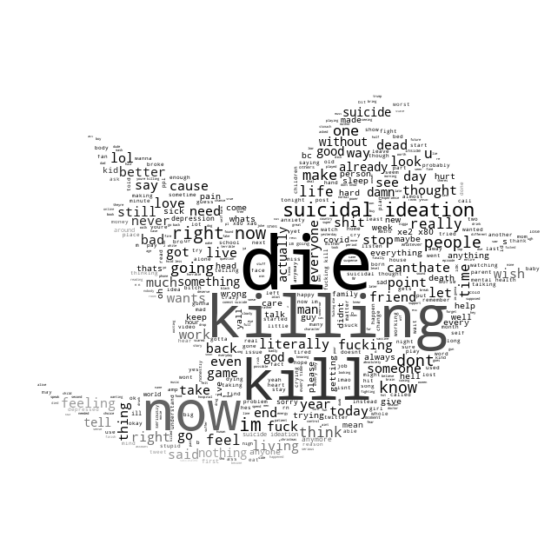

In [38]:
# Visualizing negative tweets in a word cloud format
neg_tweets = df_clean[df_clean.target == "Negative"]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(neg_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/neg_tweets_cloud.png')


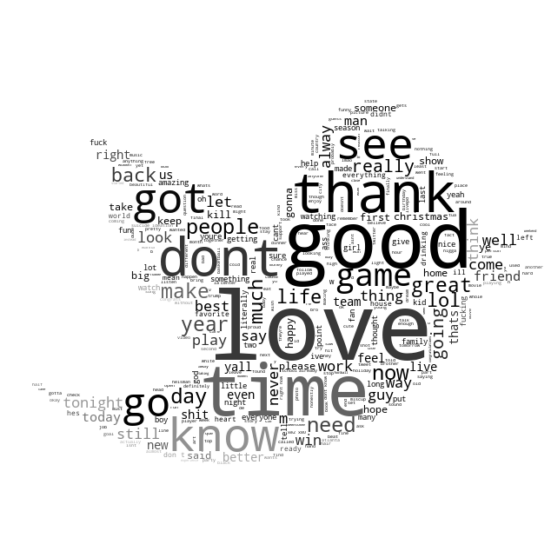

In [39]:
# Visualizing positive tweets in a word cloud format
pos_tweets = df_clean[df_clean.target == "Positive"]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
    
pos_string = pd.Series(pos_string).str.cat(sep=' ')

stopwords=set(STOPWORDS)
more_stopwords= {'will', 'want', 'im', 'u', 's', 'die', 'amp', 'one'}
stopwords= stopwords.union(more_stopwords)

mask_image= np.array(Image.open('images/twitter_mask.jpg'))
wordcloud = WordCloud(background_color='white', max_words=2000, mask=mask_image, stopwords=stopwords).generate(pos_string)

fig= plt.figure()
fig.set_figwidth(14)
fig.set_figheight(10)
image_colors= ImageColorGenerator(mask_image)
wordcloud.recolor(color_func=image_colors)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file('images/positive_tweets_cloud.png')

In [10]:
# Using CountVectorizer library to analyze frequency of words in tweets
cvec = CountVectorizer()
cvec.fit(df_clean.text)

len(cvec.get_feature_names()) # outputs total number of words


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


29311

In [11]:
# Building term frequency table to observe the most frequent words in the dataset, notice that all of them are stop words.
neg_doc_matrix = cvec.transform(df_clean[df_clean.target == "Negative"].text)
pos_doc_matrix = cvec.transform(df_clean[df_clean.target == "Positive"].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,negative,positive,total
to,10319,4640,14959
the,6505,4774,11279
and,5687,2901,8588
me,4583,1221,5804
want,4541,1168,5709
you,3095,2391,5486
is,3662,1636,5298
of,3295,1959,5254
my,3477,1705,5182
it,3168,1557,4725


Text(0.5, 1.0, 'Top 500 tokens in tweets')

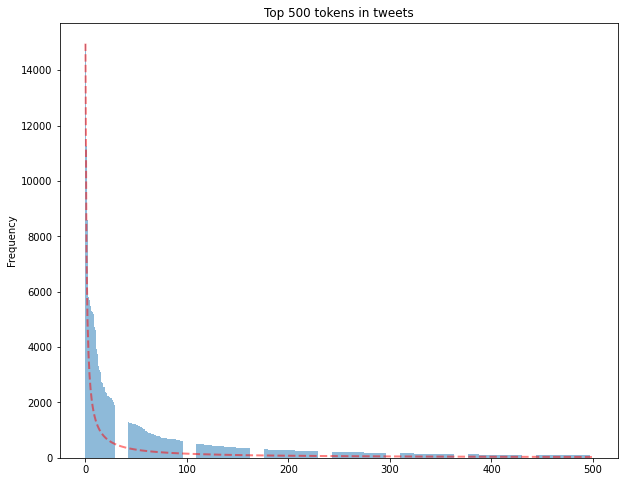

In [12]:
# Plotting tokens' frequency to see if they follow zipf's law( which states that the frequecy of the rth word => f(r) is directly prop with 1 / r)
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

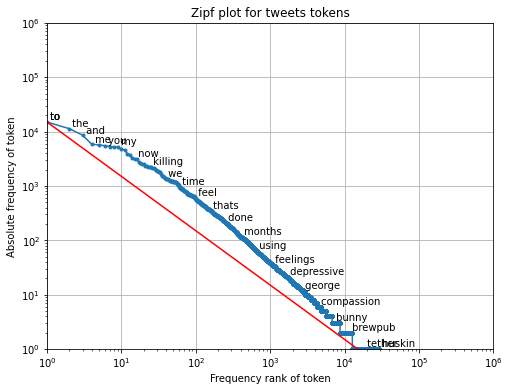

In [13]:
# Using a log-log graph, like the last one, near zipfian should be a straight line, we notice in more frequent words, their freq is above expected zipfian, and less freuent is below near zipfian
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [14]:
# Now we want to see what are the most frequent words in positive and negative tweets seperately.
cvec = CountVectorizer(stop_words='english',max_features=1000) # Removing stop words this time and limiting studied words to 10k
cvec.fit(df_clean.text)
document_matrix = cvec.transform(df_clean.text)


In [15]:
df_clean[df_clean.target == "Positive"]

,text,target
11584,"i want to finish my studies, then get a job, t...",Positive
11585,its only :45pm and i cannot wait for it to be ...,Positive
11586,just finish watch divyankatripathi latest in...,Positive
11587,sethdavishoops: no author has impacted me more...,Positive
11588,no author has impacted me more than thich nhat...,Positive
...,...,...
24064,harder to regret now that i wont get second in...,Positive
24065,o: *is born at :29pm one year ago.* my uterus...,Positive
24066,there were several moments in total history of...,Positive
24067,i love pvp i wish dead people were real,Positive


In [16]:
# Processing negative tweets
%%time
neg_batches = np.linspace(0,11594,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

1288 entries' term freuquency calculated
2576 entries' term freuquency calculated
3864 entries' term freuquency calculated
5152 entries' term freuquency calculated
6441 entries' term freuquency calculated
7729 entries' term freuquency calculated
9017 entries' term freuquency calculated
10305 entries' term freuquency calculated
11594 entries' term freuquency calculated
CPU times: user 51.6 ms, sys: 12 ms, total: 63.6 ms
Wall time: 57.4 ms


In [17]:
# Processing positive tweets
%%time
pos_batches = np.linspace(11595,24082,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

12982 entries' term freuquency calculated
14369 entries' term freuquency calculated
15757 entries' term freuquency calculated
17144 entries' term freuquency calculated
18532 entries' term freuquency calculated
19919 entries' term freuquency calculated
21307 entries' term freuquency calculated
22694 entries' term freuquency calculated
24082 entries' term freuquency calculated
CPU times: user 58.7 ms, sys: 3.2 ms, total: 61.9 ms
Wall time: 55.3 ms


In [18]:
# Displaying the top frequent words(non-stop) in both positive and negative tweets
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,negative,positive,total
want,4547,1162,5709
die,2344,740,3084
just,1576,653,2229
killing,2217,7,2224
kill,2033,138,2171
like,1272,800,2072
im,1273,726,1999
dont,829,496,1325
ideation,1153,126,1279
right,1008,232,1240


Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

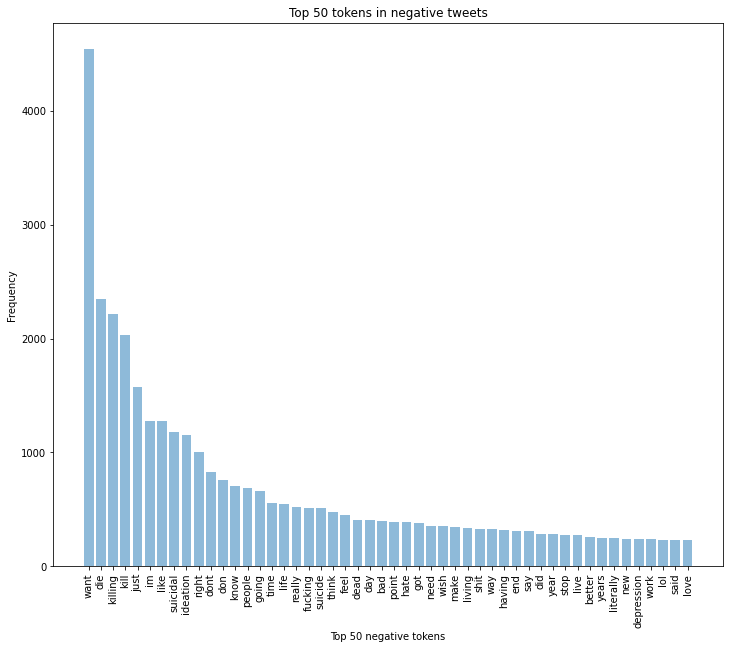

In [19]:
# Displaying most common words in negative tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')



Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

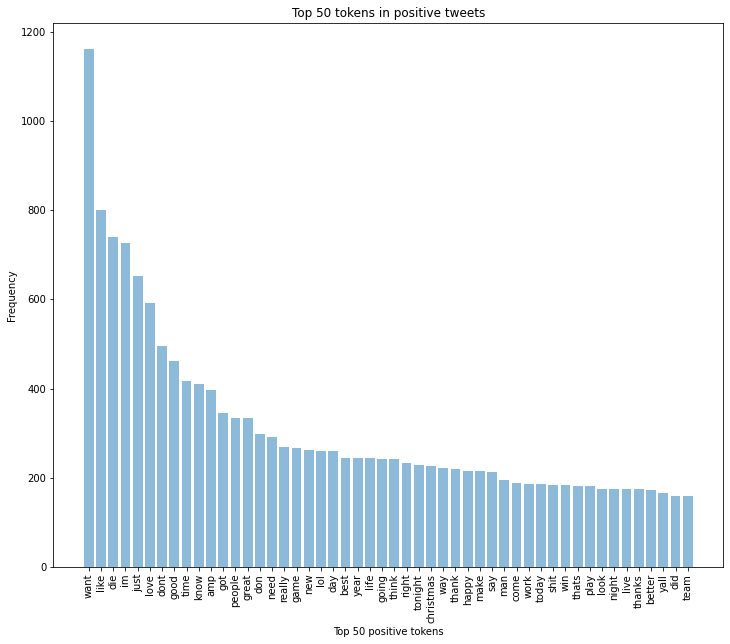

In [20]:
# Displaying most common words in positive tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

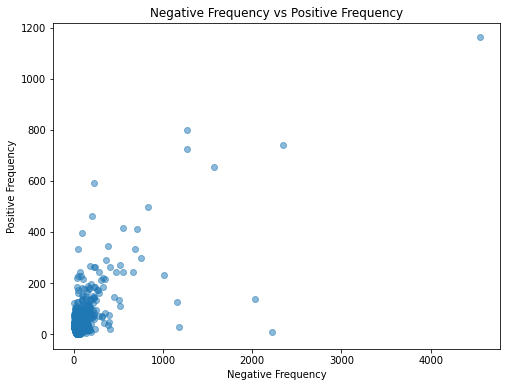

In [21]:
# We noticed in the above many neutral words occuring in both classes, let's plot the negative frequency of a word on X-axis, and the positive frequency on Y-axis
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [22]:
# As we can't infer much meaning from the previous plots, let's define a pos_rate and neg_rate, to indicate the rate of freq of a word in a certain class vs the other class
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
blessed,0,34,34,1.000000
basketball,2,46,48,0.958333
gt,7,122,129,0.945736
lights,2,33,35,0.942857
awesome,5,75,80,0.937500
atlutd,2,30,32,0.937500
congratulations,3,44,47,0.936170
congrats,5,69,74,0.932432
los,3,35,38,0.921053
stadium,3,32,35,0.914286


In [23]:
# Now let's define a freq_pct representing the rate by which a word occurs in a certain class only
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
want,4547,1162,5709,0.203538,0.023828
like,1272,800,2072,0.386100,0.016405
die,2344,740,3084,0.239948,0.015174
im,1273,726,1999,0.363182,0.014887
just,1576,653,2229,0.292956,0.013390
love,228,591,819,0.721612,0.012119
dont,829,496,1325,0.374340,0.010171
good,201,461,662,0.696375,0.009453
time,557,417,974,0.428131,0.008551
know,708,410,1118,0.366726,0.008407


In [24]:
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)               
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
want,4547,1162,5709,0.203538,0.023828,0.042661
like,1272,800,2072,0.386100,0.016405,0.031472
im,1273,726,1999,0.363182,0.014887,0.028602
die,2344,740,3084,0.239948,0.015174,0.028543
just,1576,653,2229,0.292956,0.013390,0.025610
love,228,591,819,0.721612,0.012119,0.023837
dont,829,496,1325,0.374340,0.010171,0.019804
good,201,461,662,0.696375,0.009453,0.018653
time,557,417,974,0.428131,0.008551,0.016767
know,708,410,1118,0.366726,0.008407,0.016438


In [25]:
#for positive words
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])

term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])

term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])

term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
great,44,333,377,0.883289,0.006828,0.013552,0.985198,0.999806,0.992448
amp,97,397,494,0.803644,0.008141,0.016118,0.963102,0.999993,0.981201
christmas,46,227,273,0.831502,0.004655,0.009258,0.972786,0.986947,0.979815
thank,42,219,261,0.839080,0.004491,0.008934,0.975019,0.983198,0.979091
best,66,244,310,0.787097,0.005003,0.009944,0.956124,0.992591,0.974016
win,38,183,221,0.828054,0.003753,0.007471,0.971716,0.953076,0.962306
love,228,591,819,0.721612,0.012119,0.023837,0.917550,1.000000,0.957003
tonight,85,229,314,0.729299,0.004696,0.009332,0.923092,0.987763,0.954333
thanks,44,174,218,0.798165,0.003568,0.007104,0.960900,0.940986,0.950839
good,201,461,662,0.696375,0.009453,0.018653,0.897244,1.000000,0.945839


In [26]:
#For Negative words
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']

term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()

term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])

term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])

term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])

term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
killing,2217,7,2224,0.003147,0.000144,0.000275,0.017575,0.301072,0.033211,0.996853,0.027564,0.053644,0.982425,1.000000,0.991135
suicidal,1182,29,1211,0.023947,0.000595,0.001161,0.022458,0.402561,0.042543,0.976053,0.014696,0.028955,0.977542,1.000000,0.988643
kill,2033,138,2171,0.063565,0.002830,0.005418,0.034940,0.867311,0.067173,0.936435,0.025276,0.049223,0.965060,1.000000,0.982219
ideation,1153,126,1279,0.098514,0.002584,0.005035,0.050227,0.832475,0.094738,0.901486,0.014335,0.028221,0.949773,0.999999,0.974239
dead,405,21,426,0.049296,0.000431,0.000854,0.029910,0.364455,0.055284,0.950704,0.005035,0.010018,0.970090,0.927511,0.948323
right,1008,232,1240,0.187097,0.004757,0.009279,0.112815,0.988903,0.202525,0.812903,0.012532,0.024684,0.887185,0.999984,0.940214
hate,388,36,424,0.084906,0.000738,0.001464,0.043738,0.436696,0.079512,0.915094,0.004824,0.009597,0.956262,0.916386,0.935899
fucking,513,108,621,0.173913,0.002215,0.004374,0.101007,0.770144,0.178591,0.826087,0.006378,0.012658,0.898993,0.973961,0.934977
bad,398,48,446,0.107623,0.000984,0.001951,0.054983,0.496181,0.098997,0.892377,0.004948,0.009842,0.945017,0.923076,0.933917
want,4547,1162,5709,0.203538,0.023828,0.042661,0.128879,1.000000,0.228331,0.796462,0.056532,0.105571,0.871121,1.000000,0.931122


Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

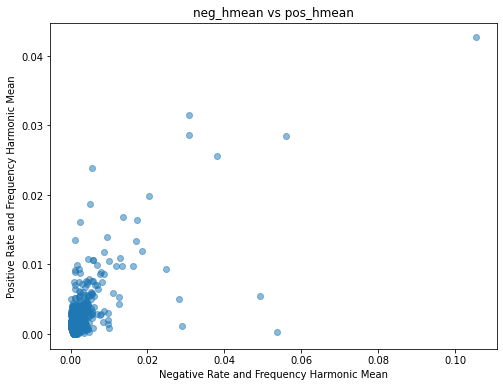

In [27]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

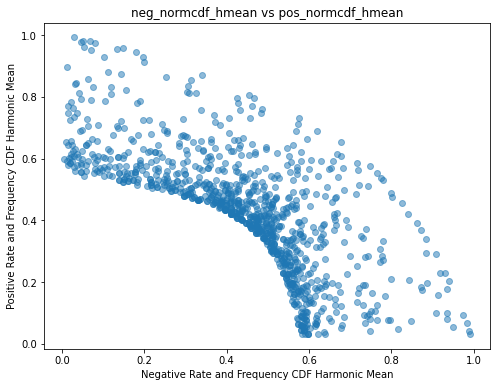

In [28]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [29]:
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))

p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')

p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})

hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

In [30]:
x = df_clean.text
y = df_clean.target

SEED = 2000

#split clean data to two sets : training , validation and test
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
#split the second set into two other sets : validation , test 
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == "Negative"]) / (len(x_train)*1.))*100,(len(x_train[y_train == "Positive"]) / (len(x_train)*1.))*100))

print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == "Negative"]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == "Positive"]) / (len(x_validation)*1.))*100))

print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == "Negative"]) / (len(x_test)*1.))*100,(len(x_test[y_test == "Positive"]) / (len(x_test)*1.))*100))




Train set has total 19255 entries with 48.11% negative, 51.89% positive
Validation set has total 2407 entries with 49.44% negative, 50.56% positive
Test set has total 2407 entries with 46.99% negative, 53.01% positive


In [31]:
print(y_validation)

7918     Negative
21153    Positive
10409    Negative
20434    Positive
9412     Negative
           ...   
14735    Positive
3714     Negative
14264    Positive
3516     Negative
14182    Positive
Name: target, Length: 2407, dtype: object


In [32]:
# Using Text Blob Python libary for sentiment analysis as baseline for accuracy

tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
target_names = ['Positive', 'Negative']
tbpred = ["Negative" if n < 0 else "Positive" for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=["Positive","Negative"]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0.
print ("Classification Report\n")
print (classification_report(y_validation, tbpred,target_names=target_names))

Accuracy Score: 62.53%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                1086                 131
negative                 771                 419
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    Positive       0.76      0.35      0.48      1190
    Negative       0.58      0.89      0.71      1217

    accuracy                           0.63      2407
   macro avg       0.67      0.62      0.59      2407
weighted avg       0.67      0.63      0.60      2407



In [33]:
#calculate accuracy for any classifer using {"null accuracy"} and get total time for training and testing
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


In [34]:
def nfeature_accuracy_checker(vectorizer=None, n_features=None, stop_words=None, ngram_range=(1, 1), classifier=None):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [35]:
#calculate accuracy for any classifer using {"null accuracy"} and get total time for training and testing
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == "Negative"]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == "Negative"]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == "Negative"]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


In [36]:
# Using count vectorizer to extract features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(2000,30001,2000)


# Unigrams without stop words
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words='english', classifier=lr)


RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression()


Validation result for 2000 features
null accuracy: 50.56%
accuracy score: 87.54%
model is 36.98% more accurate than null accuracy
train and test time: 0.86s
--------------------------------------------------------------------------------
Validation result for 4000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.16%
model is 37.60% more accurate than null accuracy
train and test time: 0.91s
--------------------------------------------------------------------------------
Validation result for 6000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.74%
model is 37.18% more accurate than null accuracy
train and test time: 0.93s
--------------------------------------------------------------------------------
Validation result for 8000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 0.96s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.66%
model is 37.10% more accurate than null accuracy
train and test time: 1.21s
--------------------------------------------------------------------------------
Validation result for 12000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.58%
model is 37.02% more accurate than null accuracy
train and test time: 1.66s
--------------------------------------------------------------------------------
Validation result for 14000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.62%
model is 37.06% more accurate than null accuracy
train and test time: 1.61s
--------------------------------------------------------------------------------
Validation result for 16000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.62%
model is 37.06% more accurate than null accuracy
train and test time: 1.79s
--------------------------------------------------------------------------------
Validation result for 18000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.62%
model is 37.06% more accurate than null accuracy
train and test time: 1.63s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.66%
model is 37.10% more accurate than null accuracy
train and test time: 1.58s
--------------------------------------------------------------------------------
Validation result for 22000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.62%
model is 37.06% more accurate than null accuracy
train and test time: 1.78s
--------------------------------------------------------------------------------
Validation result for 24000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.66%
model is 37.10% more accurate than null accuracy
train and test time: 1.75s
--------------------------------------------------------------------------------
Validation result for 26000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.58%
model is 37.02% more accurate than null accuracy
train and test time: 1.71s
--------------------------------------------------------------------------------
Validation result for 28000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.58%
model is 37.02% more accurate than null accuracy
train and test time: 1.78s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.56%
accuracy score: 87.58%
model is 37.02% more accurate than null accuracy
train and test time: 1.83s
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [37]:
# Unigrams with stop words 
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, classifier=lr)

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 2000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.20%
model is 37.64% more accurate than null accuracy
train and test time: 0.97s
--------------------------------------------------------------------------------
Validation result for 4000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.20%
model is 37.64% more accurate than null accuracy
train and test time: 0.99s
--------------------------------------------------------------------------------
Validation result for 6000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.83%
model is 37.27% more accurate than null accuracy
train and test time: 1.00s
--------------------------------------------------------------------------------
Validation result for 8000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.83%
model is 37.27% more accurate than null accuracy
train and test time: 1.00s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.83%
model is 37.27% more accurate than null accuracy
train and test time: 1.27s
--------------------------------------------------------------------------------
Validation result for 12000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.83%
model is 37.27% more accurate than null accuracy
train and test time: 1.76s
--------------------------------------------------------------------------------
Validation result for 14000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.83%
model is 37.27% more accurate than null accuracy
train and test time: 1.78s
--------------------------------------------------------------------------------
Validation result for 16000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.87%
model is 37.31% more accurate than null accuracy
train and test time: 1.73s
--------------------------------------------------------------------------------
Validation result for 18000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 1.76s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.03%
model is 37.47% more accurate than null accuracy
train and test time: 1.76s
--------------------------------------------------------------------------------
Validation result for 22000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 1.82s
--------------------------------------------------------------------------------
Validation result for 24000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.03%
model is 37.47% more accurate than null accuracy
train and test time: 1.87s
--------------------------------------------------------------------------------
Validation result for 26000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.08%
model is 37.52% more accurate than null accuracy
train and test time: 1.93s
--------------------------------------------------------------------------------
Validation result for 28000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.08%
model is 37.52% more accurate than null accuracy
train and test time: 1.77s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.56%
accuracy score: 88.08%
model is 37.52% more accurate than null accuracy
train and test time: 1.94s
--------------------------------------------------------------------------------
CPU times: user 22.5 s, sys: 14.1 s, total: 36.6 s
Wall time: 23.5 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [38]:
# Defining custom stop words as top 10 most frequent words in the dataset
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

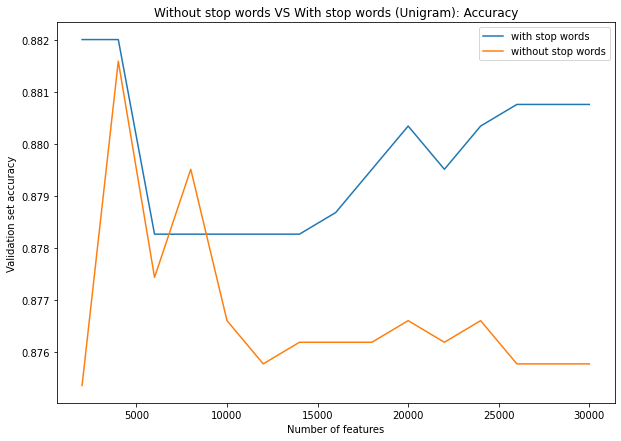

In [39]:
# Plotting the 2 cases of unigrams against each other (with stop words, without stop words)
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# NOTE: Results showed that training with stop words produces a better accuracy, so bigrams and trigrams will be processed with stop words

In [40]:
# Bigrams
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 2), classifier=lr)

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 2000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.29%
model is 36.73% more accurate than null accuracy
train and test time: 2.15s
--------------------------------------------------------------------------------
Validation result for 4000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.08%
model is 37.52% more accurate than null accuracy
train and test time: 2.22s
--------------------------------------------------------------------------------
Validation result for 6000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.24%
model is 37.68% more accurate than null accuracy
train and test time: 2.26s
--------------------------------------------------------------------------------
Validation result for 8000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.20%
model is 37.64% more accurate than null accuracy
train and test time: 2.25s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.12%
model is 37.56% more accurate than null accuracy
train and test time: 2.51s
--------------------------------------------------------------------------------
Validation result for 12000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 3.00s
--------------------------------------------------------------------------------
Validation result for 14000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.08%
model is 37.52% more accurate than null accuracy
train and test time: 3.03s
--------------------------------------------------------------------------------
Validation result for 16000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.12%
model is 37.56% more accurate than null accuracy
train and test time: 2.96s
--------------------------------------------------------------------------------
Validation result for 18000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.28%
model is 37.72% more accurate than null accuracy
train and test time: 2.94s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.08%
model is 37.52% more accurate than null accuracy
train and test time: 3.23s
--------------------------------------------------------------------------------
Validation result for 22000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.03%
model is 37.47% more accurate than null accuracy
train and test time: 3.01s
--------------------------------------------------------------------------------
Validation result for 24000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 3.13s
--------------------------------------------------------------------------------
Validation result for 26000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.99%
model is 37.43% more accurate than null accuracy
train and test time: 3.48s
--------------------------------------------------------------------------------
Validation result for 28000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.83%
model is 37.27% more accurate than null accuracy
train and test time: 3.08s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 3.50s
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [41]:
# Triagrams
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 3), classifier=lr)


RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression()


Validation result for 2000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.41%
model is 36.85% more accurate than null accuracy
train and test time: 3.75s
--------------------------------------------------------------------------------
Validation result for 4000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.24%
model is 37.68% more accurate than null accuracy
train and test time: 3.79s
--------------------------------------------------------------------------------
Validation result for 6000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.24%
model is 37.68% more accurate than null accuracy
train and test time: 3.82s
--------------------------------------------------------------------------------
Validation result for 8000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.16%
model is 37.60% more accurate than null accuracy
train and test time: 3.92s
--------------------------------------------------------------------------------
Validation result for 10000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.12%
model is 37.56% more accurate than null accuracy
train and test time: 4.17s
--------------------------------------------------------------------------------
Validation result for 12000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.20%
model is 37.64% more accurate than null accuracy
train and test time: 4.60s
--------------------------------------------------------------------------------
Validation result for 14000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.87%
model is 37.31% more accurate than null accuracy
train and test time: 4.57s
--------------------------------------------------------------------------------
Validation result for 16000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 4.65s
--------------------------------------------------------------------------------
Validation result for 18000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 87.99%
model is 37.43% more accurate than null accuracy
train and test time: 4.70s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.16%
model is 37.60% more accurate than null accuracy
train and test time: 4.93s
--------------------------------------------------------------------------------
Validation result for 22000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.12%
model is 37.56% more accurate than null accuracy
train and test time: 4.98s
--------------------------------------------------------------------------------
Validation result for 24000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.03%
model is 37.47% more accurate than null accuracy
train and test time: 4.66s
--------------------------------------------------------------------------------
Validation result for 26000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.12%
model is 37.56% more accurate than null accuracy
train and test time: 4.81s
--------------------------------------------------------------------------------
Validation result for 28000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.16%
model is 37.60% more accurate than null accuracy
train and test time: 4.70s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 50.56%
accuracy score: 88.16%
model is 37.60% more accurate than null accuracy
train and test time: 4.86s
--------------------------------------------------------------------------------


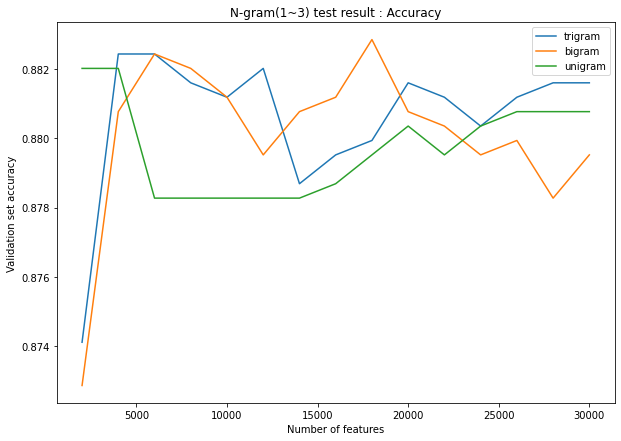

In [42]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


In [43]:
#using Tfidf algorithm to extract features
tvec = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(2000,30001,2000)


In [44]:
#with stopwords in dataset
feature_result_ugt_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, classifier=lr)


LogisticRegression()


Validation result for 2000 features
null accuracy: 50.56%
accuracy score: 88.41%
model is 37.85% more accurate than null accuracy
train and test time: 1.02s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 50.56%
accuracy score: 88.41%
model is 37.85% more accurate than null accuracy
train and test time: 0.90s
--------------------------------------------------------------------------------
Validation result for 6000 features
null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 0.87s
--------------------------------------------------------------------------------
Validation result for 8000 features
null accuracy: 50.56%
accuracy score: 87.91%
model is 37.35% more accurate than null accuracy
train and test time: 0.95s
--------------------------------------------------------------------------------
Validation result for 100

In [45]:
#with out stop words in data set
feature_result_ugt_out_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, stop_words='english', classifier=lr)


LogisticRegression()


Validation result for 2000 features
null accuracy: 50.56%
accuracy score: 87.87%
model is 37.31% more accurate than null accuracy
train and test time: 0.77s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 50.56%
accuracy score: 87.87%
model is 37.31% more accurate than null accuracy
train and test time: 0.77s
--------------------------------------------------------------------------------
Validation result for 6000 features
null accuracy: 50.56%
accuracy score: 87.74%
model is 37.18% more accurate than null accuracy
train and test time: 0.76s
--------------------------------------------------------------------------------
Validation result for 8000 features
null accuracy: 50.56%
accuracy score: 87.45%
model is 36.89% more accurate than null accuracy
train and test time: 0.73s
--------------------------------------------------------------------------------
Validation result for 100

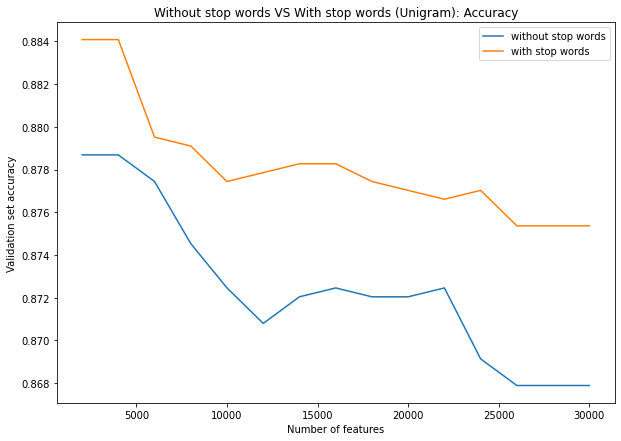

In [46]:
# unigrams against each other (with stop words, with custom stop words, without stop words) In TfIDF
nfeatures_plot_ugt_out_sw = pd.DataFrame(feature_result_ugt_out_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt_sw = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_ugt_out_sw.nfeatures, nfeatures_plot_ugt_out_sw.validation_accuracy, label='without stop words')
plt.plot(nfeatures_plot_ugt_sw.nfeatures, nfeatures_plot_ugt_sw.validation_accuracy,label='with stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [47]:
#Bigram with stop words
feature_result_bgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 2), classifier=lr)


LogisticRegression()


Validation result for 2000 features
null accuracy: 50.56%
accuracy score: 87.83%
model is 37.27% more accurate than null accuracy
train and test time: 2.10s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 50.56%
accuracy score: 88.49%
model is 37.93% more accurate than null accuracy
train and test time: 2.01s
--------------------------------------------------------------------------------
Validation result for 6000 features
null accuracy: 50.56%
accuracy score: 88.37%
model is 37.81% more accurate than null accuracy
train and test time: 2.23s
--------------------------------------------------------------------------------
Validation result for 8000 features
null accuracy: 50.56%
accuracy score: 88.08%
model is 37.52% more accurate than null accuracy
train and test time: 2.04s
--------------------------------------------------------------------------------
Validation result for 100

In [48]:
#Trigram with stop words
feature_result_tgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 3), classifier=lr)


LogisticRegression()


Validation result for 2000 features
null accuracy: 50.56%
accuracy score: 87.95%
model is 37.39% more accurate than null accuracy
train and test time: 3.77s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 50.56%
accuracy score: 88.41%
model is 37.85% more accurate than null accuracy
train and test time: 3.70s
--------------------------------------------------------------------------------
Validation result for 6000 features
null accuracy: 50.56%
accuracy score: 88.45%
model is 37.89% more accurate than null accuracy
train and test time: 3.66s
--------------------------------------------------------------------------------
Validation result for 8000 features
null accuracy: 50.56%
accuracy score: 88.24%
model is 37.68% more accurate than null accuracy
train and test time: 3.71s
--------------------------------------------------------------------------------
Validation result for 100

In [49]:
feature_result_tgt_sw_3_3 = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(3, 3), classifier=lr)


LogisticRegression()


Validation result for 2000 features
null accuracy: 50.56%
accuracy score: 79.10%
model is 28.54% more accurate than null accuracy
train and test time: 1.96s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 50.56%
accuracy score: 79.31%
model is 28.75% more accurate than null accuracy
train and test time: 1.86s
--------------------------------------------------------------------------------
Validation result for 6000 features
null accuracy: 50.56%
accuracy score: 79.43%
model is 28.87% more accurate than null accuracy
train and test time: 1.99s
--------------------------------------------------------------------------------
Validation result for 8000 features
null accuracy: 50.56%
accuracy score: 79.27%
model is 28.71% more accurate than null accuracy
train and test time: 1.95s
--------------------------------------------------------------------------------
Validation result for 100

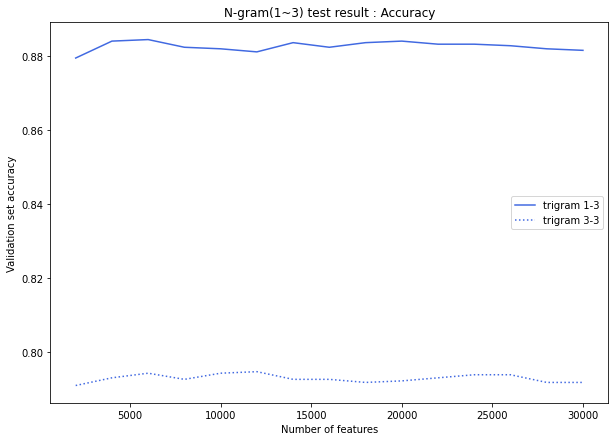

In [50]:
# Plotting trigram (1,3) features Vs trigram (3,3) features


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tgt_3_3 = pd.DataFrame(feature_result_tgt_sw_3_3,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram 1-3',color='royalblue')
plt.plot(nfeatures_plot_tgt_3_3.nfeatures, nfeatures_plot_tgt_3_3.validation_accuracy,label='trigram 3-3',linestyle=':', color='royalblue')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

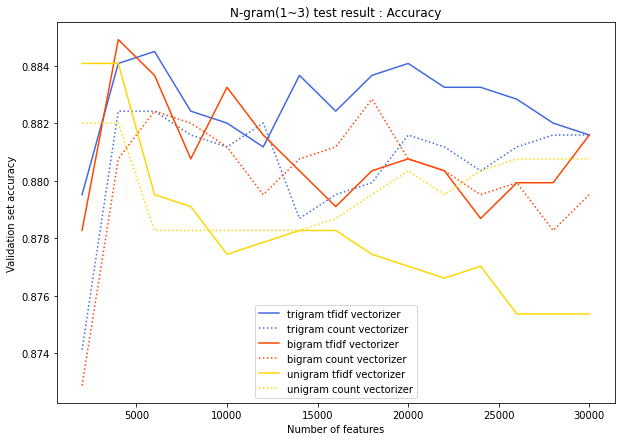

In [51]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph based on (countvectorizer & tfidf)

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,7))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [67]:
# Trying several classifiers and comparison between them 

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

#comparator to compare between accuracy of different zipped classifiers

def classifier_comparator(vectorizer=tvec, n_features=None, stop_words=None, ngram_range=None, classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=29311,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 50.56%
accuracy score: 88.28%
model is 37.72% more accurate than null accuracy
train and test time: 4.49s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 50.56%
accuracy score: 89.24%
model is 38.68% more accurate than null accuracy
train and test time: 3.63s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
null accuracy: 50.56%
accuracy score: 89.86%
model is 39.30% more accurate than null accuracy
train and test time: 4.18s
--------------------------------------------------------------------------------

In [62]:
#use top 5 of classifiers and use VotingClassifier with voting hard
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = AdaBoostClassifier()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')
checker_pipeline = Pipeline([
              ('vectorizer', TfidfVectorizer(max_features=29311,ngram_range=(1, 3))),
              ('classifier', eclf)
])
print ("Validation result for {}".format('Ensemble'))
print (eclf)
accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)


Validation result for Ensemble
VotingClassifier(estimators=[('lr', LogisticRegression()), ('svc', LinearSVC()),
                             ('mnb', AdaBoostClassifier()),
                             ('rcs', RidgeClassifier()),
                             ('pac', PassiveAggressiveClassifier())])
null accuracy: 50.56%
accuracy score: 88.95%
model is 38.39% more accurate than null accuracy
train and test time: 9.84s
--------------------------------------------------------------------------------


(0.8894889904445368, 9.842464923858643)

In [54]:
from keras.models import Sequential
from keras.models import Sequential
import pickle

In [55]:
cv= CountVectorizer()
Xnew = cv.fit_transform(df_clean.text).toarray()


In [56]:
Xnewdf= pd.DataFrame(Xnew)
Xnewdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,29271,29272,29273,29274,29275,29276,29277,29278,29279,29280,29281,29282,29283,29284,29285,29286,29287,29288,29289,29290,29291,29292,29293,29294,29295,29296,29297,29298,29299,29300,29301,29302,29303,29304,29305,29306,29307,29308,29309,29310
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
def predict_tweet():
  input_str = input('Enter elements of a list separated by space: ')
  input_tweet = input_str.split("$fdaf%%fd%%$")
  print(input_tweet)


  #input_tweet = ["I dont know what to do anymore I lost my job, my wife left me. I am so fed up with my life"] // input should be entered in list type

  input_num = cv.fit_transform(input_tweet).toarray()
  inputdf= pd.DataFrame(input_num)

  # check which columns are expected by the model, but not exist in the inference dataframe
  not_existing_cols = [c for c in Xnewdf.columns.tolist() if c not in inputdf]
  # add this columns to the data frame
  inputdf = inputdf.reindex(inputdf.columns.tolist() + not_existing_cols, axis=1)
  # new columns dont have values, replace null by 0
  inputdf.fillna(0, inplace = True)
  # use the original X structure as mask for the new inference dataframe
  inputdf = inputdf[Xnewdf.columns.tolist()]

  print("The sentiment of input tweet is: " + eclf.predict(inputdf))


In [68]:
#predict_tweet()